This notebook compares the difference between the normal computation of the samples and the computation of the samples with multithreading. This notebook tests the same theory as the fast lattice notebook. However, was done with different numbers and formatted differently for easier comparison with the notebooks that will precede this one.

In [8]:
import qmcpy as qp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#cProfile is used to record the execution time of code.
import cProfile
#pstats lets us manipulate and view the results from profiled code.
import pstats

**Defining the functions**

Here we define the different funtion that will be used. You can see the threading option is toggled by a boolean. A specific seed is used to eliminate variability and facilitate result reproducibility.

In [9]:
test_seed = 24
def natural(n, point_num, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,thread=False)
    points = l.gen_samples(point_num) 
    return points
def linear(n, point_num, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,thread=False)
    points = l.gen_samples(point_num) 
    return points
def mps(n, point_num, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,thread=False)
    points = l.gen_samples(point_num) 
    return points
def natural_thread(n, point_num, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,thread=True)
    points = l.gen_samples(point_num) 
    return points
def linear_thread(n, point_num, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,thread=True)
    points = l.gen_samples(point_num) 
    return points
def mps_thread(n, point_num, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,thread=True)
    points = l.gen_samples(point_num) 
    return points


**Having fixed sample points (2^n) with variable dimension**

Here we run the functions and get their execution times. Trials define the number of times we run each dimension. A larger number of trials give us a larger number of samples, helping to reduce edge cases. 

The results of the profiling are stored into a data frame where a column represents a way of computing and the row is the number of dimensions.

In [10]:
trials = 5
dimension_list = [50, 100, 200, 500, 1400, 3500]
n = 10
data = {'Dimensions':dimension_list}
dimension_frame = pd.DataFrame(data)
dimension_frame = dimension_frame.set_index('Dimensions')
names = set()

#Functions that are ran, you need to pass a tuple with (function name, name you want to assign)
run_list = [(natural, "natural"),(linear, "linear"),(mps,"mps"),(natural_thread, "natural thread"),(linear_thread,"linear thread"),(mps_thread, "mps thread")]

for method,method_name in run_list:

    name = method_name.split(" ")

    names.add(name[0])

    times = []
    
    for d in dimension_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, 2 ** n,seed=test_seed)
        profiler.disable()
        
        stats = pstats.Stats(profiler)
            
        process_time = stats.total_tt

        times.append(process_time)
        
    dimension_frame[method_name] = times  
stats.sort_stats('cumulative')


names = list(names)  


**Computing the results for constant point number and variable dimension** 

The comparison list compares the different runtimes between each function. The functions you want to compare are put into a tuple like (a, b). The runtime of function a is divided by b. Giving the speed-up factor with regard to the second function. This means that an end result of above 1 would mean function b is faster than function a. Then these results are added to the original frame.

In [11]:
#The functions are referenced by the names they were given eariler in the dataframe.
comparison= [('mps', 'mps thread'), ('linear', 'linear thread'), ('natural', 'natural thread')]



def speed_up_cal(data_frame, compare_list, column_list, end_suffix):
    result = []
    for seq,pro in compare_list:
        result = []
        for x in column_list:
            a = data_frame[seq][x]
            b = data_frame[pro][x]
            result.append(a/b)
        data_frame[seq + " " + end_suffix] = result

suffix = "normal/thread speed-up" 

speed_up_cal(dimension_frame, comparison, dimension_list, suffix)


**Viewing the results for constant point number and variable dimension** 

This just uses takes the values out of the data frame and graphs them. 

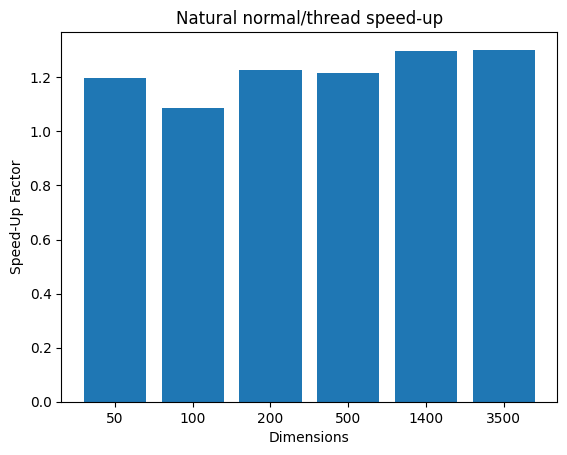

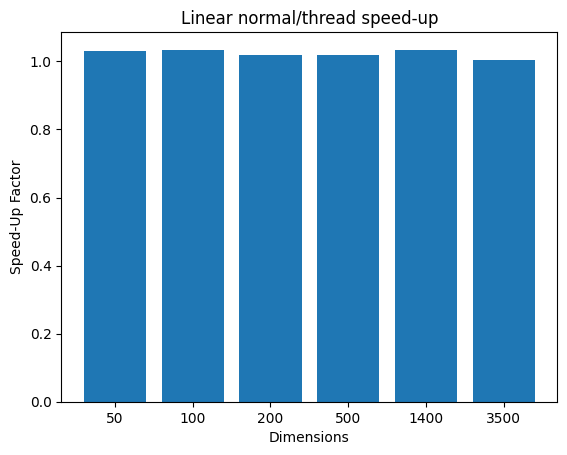

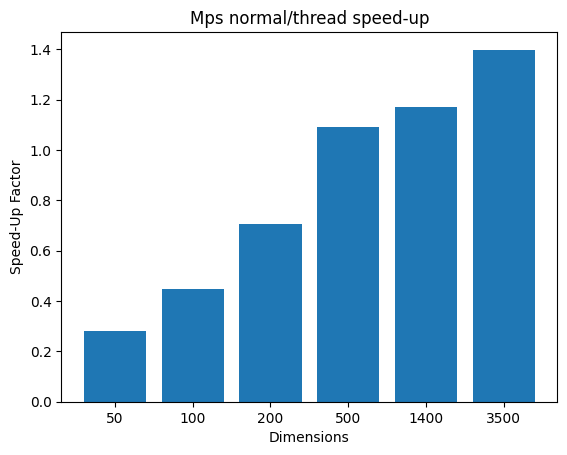

In [12]:
#Converts the column numbers into a string list for showing on the graph.
to_str_list = lambda array: [str(x) for x in array]

titles = ["Natural","Linear","Mps"]

for i in titles:
    y_axis = dimension_frame[f"{i.lower()} {suffix}"].to_numpy()
    x_axis = to_str_list(dimension_list)
    plt.bar(x_axis, y_axis)
    plt.xlabel('Dimensions')
    plt.ylabel('Speed-Up Factor')
    plt.title(f"{i} {suffix}")
    plt.show()



**There is a constant dimension (2^n) and variable number of points**

The results of the profiling are stored into a data frame where a column represents a way of computing and the row is the number of dimensions. The computing of the results is also within this cell because the function is already defined.

In [13]:
d = 10
point_list = [10, 100, 1000, 10_000, 15_000]
records = {'Points':point_list}
point_frame = pd.DataFrame(records)
point_frame = point_frame.set_index('Points')
names = set()

for method, method_name in run_list:
    name = method_name.split(" ")

    names.add(name[0])


    times = []
    
    for p in point_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(2 ** d, p,seed=test_seed)
        profiler.disable()
    
        stats = pstats.Stats(profiler)
        
        process_time = stats.total_tt


        times.append(process_time)
    
    point_frame[method_name] = times  
stats.sort_stats('cumulative')


names = list(names)     


speed_up_cal(point_frame, comparison, point_list, suffix)


**Displaying the results of fixed dimension and variable points**

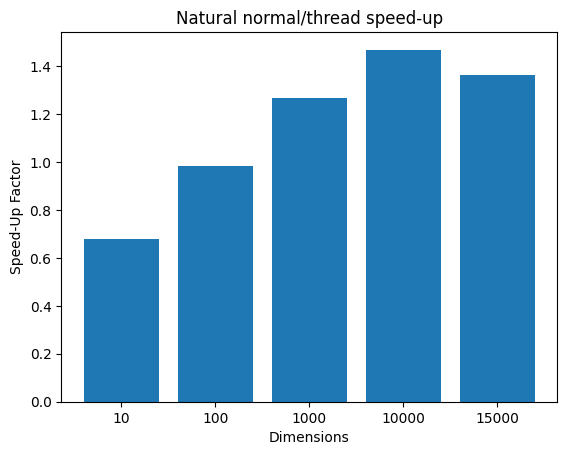

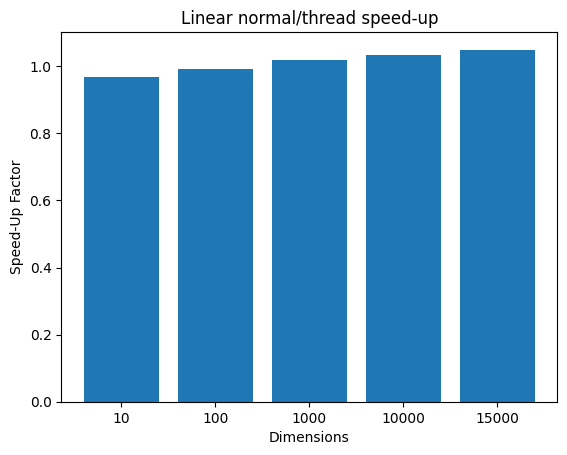

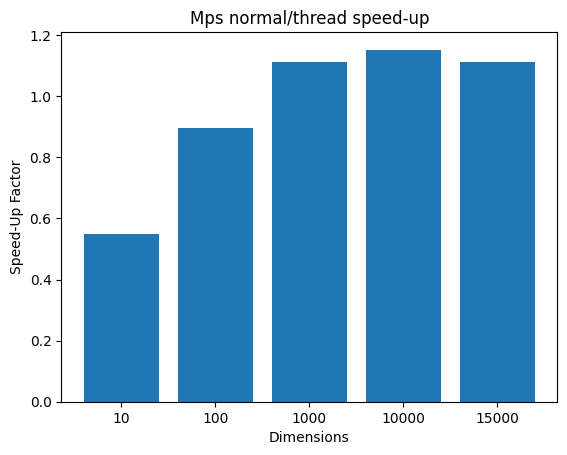

In [14]:
for i in titles:
    y_axis = point_frame[f"{i.lower()} {suffix}"].to_numpy()
    x_axis = to_str_list(point_list)
    plt.bar(x_axis, y_axis)
    plt.xlabel('Dimensions')
    plt.ylabel('Speed-Up Factor')
    plt.title(f"{i} {suffix}")
    plt.show()
